In [1]:
import os
import yaml

from lightning import Trainer, seed_everything
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from torch_geometric.nn import global_mean_pool
import torch
import torch_geometric
import umap
import numpy as np
from sklearn.feature_selection import r_regression

from virtual_screening import VirtualScreeningEmbedder, VirtualScreener, PharmacophoreAlignment
from dataset import PharmacophoreDataModule
from model import PharmCLR, PhectorMatch
from utils import load_model_from_path

import umap.plot as uplot
import CDPL.Pharm as Pharm
import sys
import pandas as pd
umap.plot.output_notebook()

/data/shared/software/conda/daniel_rose/envs/ph4/lib/python3.10/site-packages/flash/__init__.py:21: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/data/shared/software/conda/daniel_rose/envs/ph4/lib/python3.10/site-packages/flash/__init__.py:21: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):


Loading BokehJS ...

In [71]:
# Define global variables
PROJECT_ROOT = '/data/shared/projects/PhectorDB'
PRETRAINING_ROOT = f"{PROJECT_ROOT}/training_data"
VS_ROOT = f"{PROJECT_ROOT}/litpcba/ESR1_ant"
MODEL = PhectorMatch
VS_MODEL_NUMBER = 133
MODEL_PATH = f"{PROJECT_ROOT}/logs/{MODEL.__name__}/version_{VS_MODEL_NUMBER}/"
HPARAMS_FILE = "hparams.yaml"

# MODEL = PharmCLR
# VS_MODEL_NUMBER = 23
# MODEL_PATH = (
#     f"{PROJECT_ROOT}/archived/old_logs_2/{MODEL.__name__}/version_{VS_MODEL_NUMBER}/"
#     # f"{PROJECT_ROOT}/logs/{PRETRAINED_MODEL.__name__}/version_{PRETRAINED_VERSION}/"
# )

params = yaml.load(
    open(os.path.join(PROJECT_ROOT, MODEL_PATH, HPARAMS_FILE), "r"), Loader=yaml.FullLoader
)

In [72]:
# Deterministic flags (should not be necessary for inference, but just in case)
torch.set_float32_matmul_precision("medium")
torch_geometric.seed_everything(params["seed"])
seed_everything(params["seed"])
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# Setup datamodule
datamodule = PharmacophoreDataModule(
    PRETRAINING_ROOT,
    VS_ROOT,
    #batch_size=params["batch_size"],
    batch_size=64,
    small_set_size=params["num_samples"],
)
datamodule.setup()

# Load the model
model = load_model_from_path(os.path.join(PROJECT_ROOT, MODEL_PATH), MODEL)
device = [model.device.index]


trainer = Trainer(
    num_nodes=1,
    devices=device,
    max_epochs=params["epochs"],
    accelerator="auto",
    logger=False,
    log_every_n_steps=1,
)

# create embeddings
embedder = VirtualScreeningEmbedder(model, datamodule, trainer)
screener = VirtualScreener(embedder)

Seed set to 42


Number of training graphs: 20000
Number of active graphs: 1311
Number of inactive graphs: 54585


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]
/data/shared/software/conda/daniel_rose/envs/ph4/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [4]:
alignment = PharmacophoreAlignment(vs_root=VS_ROOT)
alignment.align_preprocessed_ligands_to_query()

Alignment of 1311 ph4s
Alignment took 0.8963 seconds
Alignment of 54585 ph4s
Alignment took 17.8500 seconds


In [37]:
# Compute and retrieve alignment score
active_alignment_score = torch.load(os.path.join(VS_ROOT, "vs/all_actives_aligned.pt"))
inactive_alignment_score = torch.load(os.path.join(VS_ROOT, "vs/all_inactives_aligned.pt"))
max(active_alignment_score[:, 0])

tensor(6.)

In [74]:
from sklearn.metrics import roc_curve, matthews_corrcoef, confusion_matrix
import numpy as np
from torch_geometric.nn import global_max_pool

y_true = inactive_alignment_score[:, 0] == 6
y_pred = -screener.inactive_query_match

fpr, tpr, threshold = roc_curve(y_true, y_pred)
j = tpr - fpr
idx = np.argmax(j)
best_threshold = -threshold[idx]

y_true = inactive_alignment_score[:, 0] == 6
y_pred = screener.inactive_query_match <= best_threshold

print(best_threshold)
print(matthews_corrcoef(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))

y_true = global_max_pool(inactive_alignment_score[:, 0] == 6, screener.inactive_mol_ids)
y_pred = global_max_pool(screener.inactive_query_match <= best_threshold, screener.inactive_mol_ids)
print(matthews_corrcoef(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))

0.108963154
0.0977958385950132
[[25409 28147]
 [  119   910]]
0.12322031750357244
[[1773 1914]
 [  23  122]]


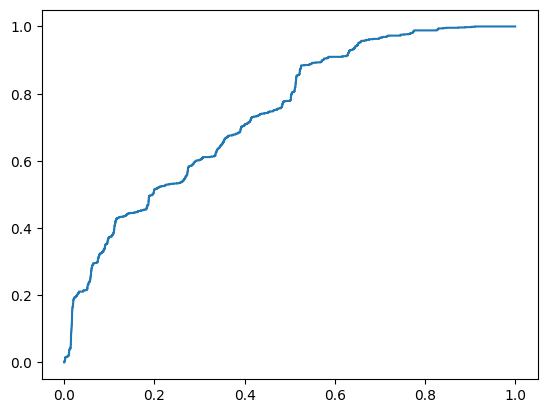

In [75]:
import matplotlib.pyplot as plt

plt.plot(fpr, tpr)


In [76]:
y_true = global_max_pool(inactive_alignment_score[:, 0] == 6, screener.inactive_mol_ids)
y_pred = global_max_pool(screener.inactives_prefilter_mask, screener.inactive_mol_ids)
#y_true = inactive_alignment_score[:, 0] == 6
#y_pred = screener.inactives_prefilter_mask
print(matthews_corrcoef(y_true, y_pred))
confusion_matrix(y_true, y_pred)

0.32399915506441007


array([[2903,  784],
       [   9,  136]])

In [30]:
model.encoder.convolution[2].att_edge.shape

torch.Size([1, 10, 256])

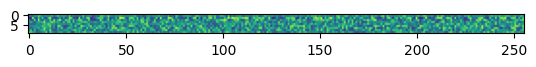

In [32]:

plt.imshow(model.encoder.convolution[0].att_edge.detach().numpy().reshape(10, 256))

In [8]:
# How well does the similarity correlate with the alignment ranking?
aligned_features = inactive_alignment_score[:, 0]
geometric_fit = inactive_alignment_score[:, 1]
num_features = inactive_alignment_score[:, 2]
y_true = aligned_features >= 6
y_pred = screener.inactive_query_match
roc_auc_score(y_true, y_pred)

0.6126184840100162

In [4]:
sum(screener.actives_prefilter_mask)

tensor(0)

In [10]:
offset = 0
active_score = active_alignment_score[:, 0] #/ active_alignment_score[:, 2] * (active_alignment_score[:, 1] + offset)
inactive_score = inactive_alignment_score[:, 0]# / inactive_alignment_score[:, 2] * (inactive_alignment_score[:, 1] + offset)
#active_score = 1 / active_alignment_score[:, 2]
#inactive_score = 1 / inactive_alignment_score[:, 2]

print(r_regression(screener.active_query_match.reshape(-1, 1), active_score.reshape(-1, 1)))
print(r_regression(screener.inactive_query_match.reshape(-1, 1), inactive_score.reshape(-1, 1)))
#print(r_regression(screener.active_query_similarity[screener.actives_prefilter_mask].reshape(-1, 1), active_score[screener.actives_prefilter_mask].reshape(-1, 1)))
print(r_regression(screener.inactive_query_match[screener.inactives_prefilter_mask].reshape(-1, 1), inactive_score[screener.inactives_prefilter_mask].reshape(-1, 1)))


[0.26292354]
[0.36964905]
[0.6014041]


/data/shared/software/conda/daniel_rose/envs/ph4/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/data/shared/software/conda/daniel_rose/envs/ph4/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/data/shared/software/conda/daniel_rose/envs/ph4/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [11]:
n_query = 7
active_jaccard = active_alignment_score[:, 0] / (active_alignment_score[:, 2] + n_query - active_alignment_score[:, 0]) 
inactive_jaccard = inactive_alignment_score[:, 0] / (inactive_alignment_score[:, 2] + n_query - inactive_alignment_score[:, 0])
print(r_regression(screener.active_query_match.reshape(-1, 1), active_jaccard.reshape(-1, 1)))
print(r_regression(screener.inactive_query_match.reshape(-1, 1), inactive_jaccard.reshape(-1, 1)))

[0.53264466]
[0.706862]


/data/shared/software/conda/daniel_rose/envs/ph4/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/data/shared/software/conda/daniel_rose/envs/ph4/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


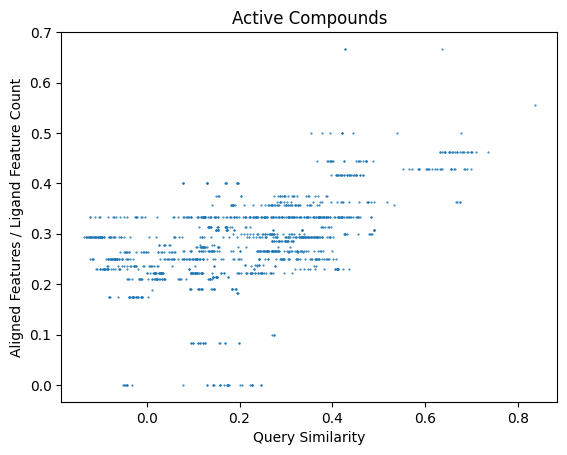

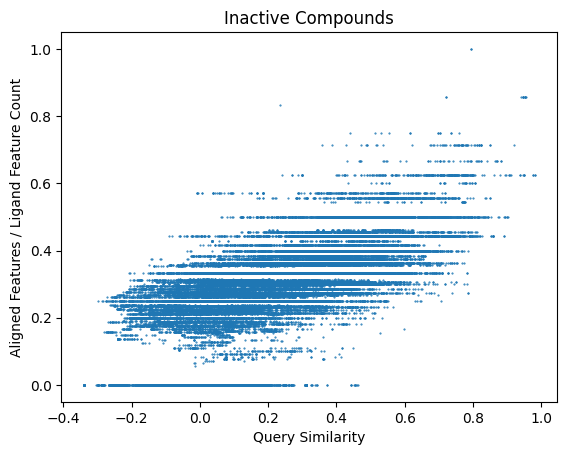

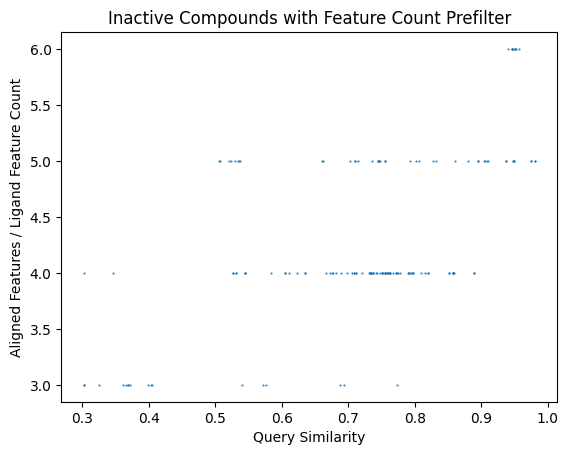

In [12]:
fig = plt.figure()
plt.scatter(screener.active_query_match, active_jaccard, marker='.', s=1)
plt.xlabel('Query Similarity')
plt.ylabel('Aligned Features / Ligand Feature Count')
plt.title('Active Compounds')
plt.show()

# fig = plt.figure()
# plt.scatter(screener.active_query_similarity[screener.actives_prefilter_mask], active_score[screener.actives_prefilter_mask], marker='.', s=1)
# plt.xlabel('Query Similarity')
# plt.ylabel('Aligned Features / Ligand Feature Count')
# plt.title('Active Compounds with Feature Count Prefilter')
# plt.show()

fig = plt.figure()
plt.scatter(screener.inactive_query_match, inactive_jaccard, marker='.', s=1)
plt.xlabel('Query Similarity')
plt.ylabel('Aligned Features / Ligand Feature Count')
plt.title('Inactive Compounds')
plt.show()

fig = plt.figure()
plt.scatter(screener.inactive_query_match[screener.inactives_prefilter_mask], inactive_score[screener.inactives_prefilter_mask], marker='.', s=1)
plt.xlabel('Query Similarity')
plt.ylabel('Aligned Features / Ligand Feature Count')
plt.title('Inactive Compounds with Feature Count Prefilter')
plt.show()

In [12]:
# fpr, tpr, _ = roc_curve(screener.y_true, screener.y_pred)
# print('ROCAUC Score:', roc_auc_score(screener.y_true, screener.y_pred))
# plt.plot(fpr, tpr)
# plt.show()

# top_active_similarity = screener.active_query_similarity[screener.active_mask]
# top_inactive_similarity = screener.inactive_query_similarity[screener.inactive_mask]
# top_active_similarity = top_active_similarity[screener.actives_prefilter_mask[screener.active_mask]]
# top_inactive_similarity = top_inactive_similarity[screener.inactives_prefilter_mask[screener.inactive_mask]]

# # Map similarity [-1, 1] --> [0, 1] and print AUC statistics
# y_pred = torch.cat(
#     (top_active_similarity, top_inactive_similarity)
# )
# #y_pred = (y_pred + 1) / 2
# y_true = torch.cat(
#     (
#         torch.ones(len(top_active_similarity), dtype=torch.int),
#         torch.zeros(len(top_inactive_similarity), dtype=torch.int),
#     )
# )

# fpr, tpr, _ = roc_curve(y_true, y_pred)
# print('ROCAUC Score:', roc_auc_score(y_true, y_pred))
# plt.plot(fpr, tpr)
# plt.show()

In [29]:
# First I train the UMAP on the latent space of the actives and inactives
# Only one representation per molecule, otherwise we get a distorted mapping
# This is why I calculate the mean representation for the conformations of each molecule
mean_actives = global_mean_pool(screener.active_embeddings, screener.active_mol_ids)
mean_inactives = global_mean_pool(screener.inactive_embeddings, screener.inactive_mol_ids)
reducer = umap.UMAP(metric="euclidean")
reducer.fit(torch.cat((mean_actives, mean_inactives)))

UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [30]:
# Now we can map the representations of the conformations into the embedding space of the UMAP 
reduced_inactive_embeddings = reducer.transform(screener.inactive_embeddings)
reduced_active_embeddings = reducer.transform(screener.active_embeddings)
reduced_query_embedding = reducer.transform(screener.query_embedding)
#reduced_top_inactive_embeddings = reducer.transform(screener.top_inactive_embeddings)
#reduced_top_active_embeddings = reducer.transform(screener.top_active_embeddings)

In [26]:
reduced_query_embedding.shape

(1, 2)

In [40]:
# I want some hover data to explore the UMAP interactively, this is generated here
def getReaderByFileExt(filename: str) -> Pharm.PharmacophoreReader:
    name_and_ext = os.path.splitext(filename)

    if name_and_ext[1] == "":
        sys.exit(
            "Error: could not determine pharmacophore input file format (file extension missing)"
        )

    # get input handler for the format specified by the input file's extension
    ipt_handler = Pharm.PharmacophoreIOManager.getInputHandlerByFileExtension(
        name_and_ext[1][1:].lower()
    )

    if not ipt_handler:
        sys.exit(
            "Error: unsupported pharmacophore input file format '%s'"
            % name_and_ext[1]
        )

    # create and return file reader instance
    return ipt_handler.createReader(filename)

# Create dataframe for hover data
inactive_path = os.path.join(VS_ROOT, 'raw', 'inactives.psd')
active_path = os.path.join(VS_ROOT, 'raw', 'actives.psd') 
query_path = os.path.join(VS_ROOT, 'raw', 'query.pml')

def create_metadata(path):
    reader = getReaderByFileExt(path)
    ph4 = Pharm.BasicPharmacophore()
    names = []
    features = []
    index = []
    conf_index = []
    num_features = []
    conf = 0
    i = 0 
    name = ''

    while reader.read(ph4):
        if ph4.getNumFeatures() == 0:
            continue
        feature_types = Pharm.generateFeatureTypeHistogramString(ph4)
        if name == Pharm.getName(ph4):
            conf += 1
        else:
            conf = 0
            name = Pharm.getName(ph4)
        conf_index.append(conf)
        features.append(feature_types)
        names.append(name)
        index.append(i)
        num_features.append(ph4.getNumFeatures())
        i += 1

    metadata = pd.DataFrame({'index': index, 'name':names, 'conf_idx': conf_index, 'features': features, 'num_features': num_features})

    return metadata

inactive_metadata = create_metadata(inactive_path) 
active_metadata = create_metadata(active_path) 
query_metadata = create_metadata(query_path)

In [58]:
hover_data['num_features'].values

array([13, 13, 13, ..., 13, 13,  6])

In [32]:
# The interactive UMAP plot can't handle too much datapoints, so here we can reduce their number by some threshold 
max_num_inactives = 30000
hover_data = pd.concat((inactive_metadata[:max_num_inactives], active_metadata, query_metadata), ignore_index=True)
points = np.concatenate((reduced_inactive_embeddings[:max_num_inactives], reduced_active_embeddings, reduced_query_embedding))
labels = np.concatenate((np.zeros(len(reduced_inactive_embeddings[:max_num_inactives])), np.ones(len(reduced_active_embeddings)), np.ones(len(reduced_query_embedding))*2))
reducer.embedding_ = points

In [33]:
# The extracted metadata looks like this:
len(points)

31312

In [34]:
p = uplot.interactive(reducer, labels=labels, theme='inferno', hover_data=hover_data, point_size=4)
umap.plot.show(p)

In [63]:
from sklearn.decomposition import PCA

inactive_counts = inactive_metadata['num_features'].values
pca = PCA(n_components=4)
inactive_transformed = pca.fit_transform(screener.inactive_embeddings)

In [64]:
pca.explained_variance_ratio_

array([0.27344073, 0.2656519 , 0.17472646, 0.09396538])

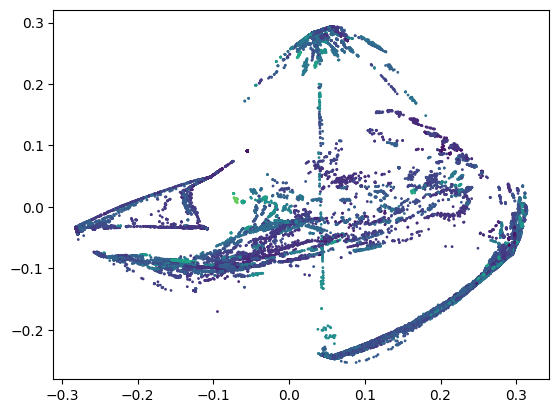

In [65]:
plt.scatter(inactive_transformed[:, 0], inactive_transformed[:, 1 ], c=inactive_counts, cmap='viridis', s=1)

In [41]:
import re

def get_feature_count(feature, hover_data):
    feature_count = []
    count = 0
    for feature_string in hover_data['features']:
        if f'{feature}(' in feature_string:
            for str in feature_string.split(','):
                if f'{feature}(' in str:
                    count = int(re.findall(r'\d+', str)[0])
        else: 
            count = 0
        feature_count.append(count)

    return feature_count

feature = 'XBD'
feature_count = get_feature_count(feature, hover_data)
#feature_count = hover_data['num_features'].values

p = uplot.interactive(reducer, values=feature_count, theme='darkblue', hover_data=hover_data, point_size=2)
umap.plot.show(p)

/tmp/ipykernel_77991/4071531605.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  new_cmap = cm.get_cmap(cmap_str, 256)


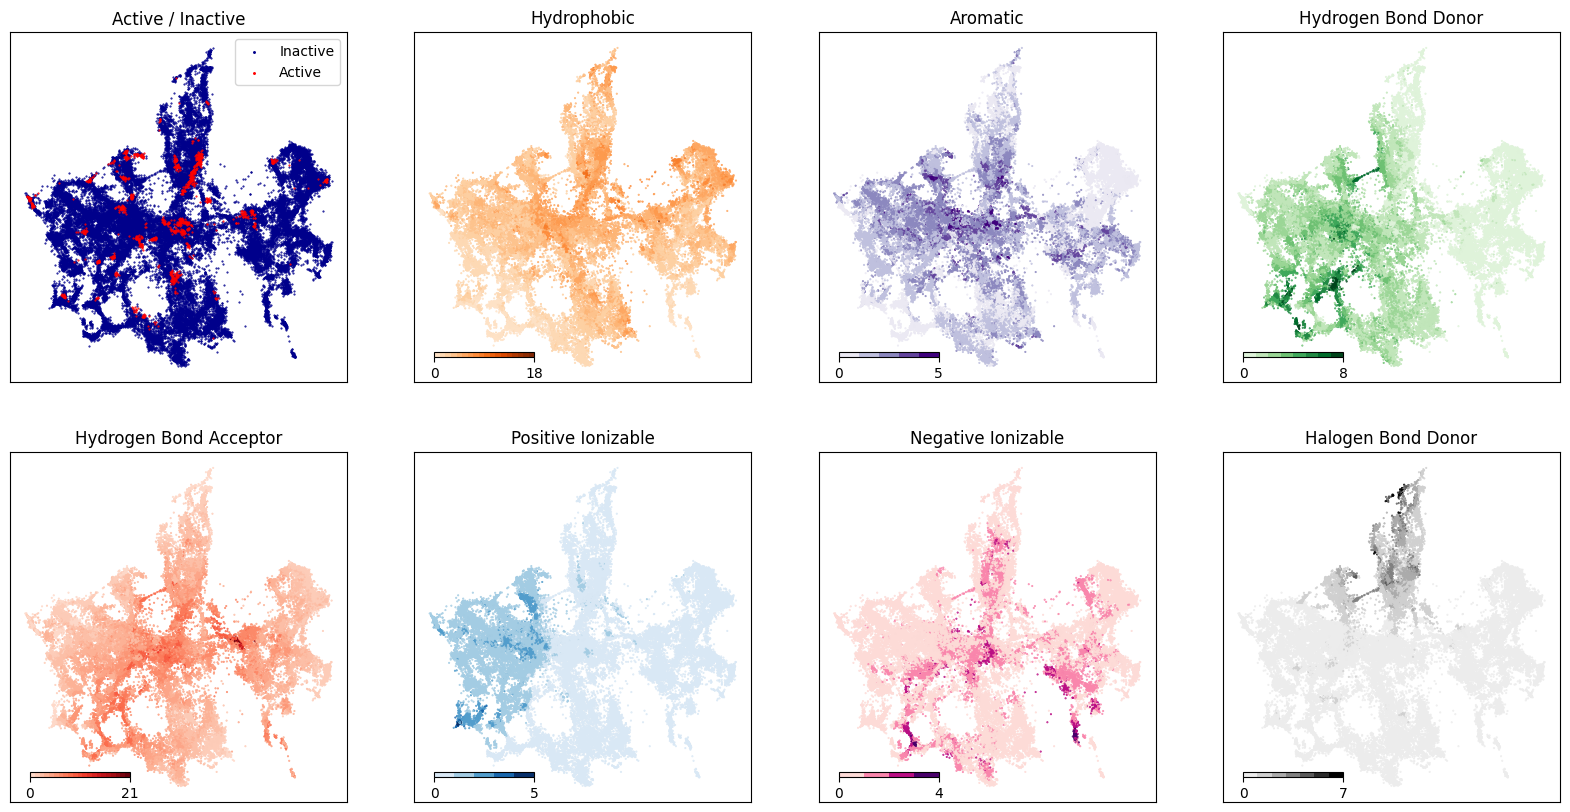

In [46]:
from matplotlib import cm
from matplotlib.colors import ListedColormap

max_num_inactives = -1
hover_data = pd.concat((inactive_metadata[:max_num_inactives], active_metadata, query_metadata), ignore_index=True)
points = np.concatenate((reduced_inactive_embeddings[:max_num_inactives], reduced_active_embeddings, reduced_query_embedding))

fig1, axes = plt.subplots(2, 4, figsize=(20, 10), sharex=True, sharey=True)

# Plot actives and inactives
ax = axes[0][0]
sc = ax.scatter(reduced_inactive_embeddings[:, 0], reduced_inactive_embeddings[:, 1], c='darkblue', s=1, alpha=1, marker='.')
sc = ax.scatter(reduced_active_embeddings[:, 0], reduced_active_embeddings[:, 1], c='red', s=1, alpha=1, marker='.')
#ax.set_xlim((0, 15))
#ax.set_ylim((-4, 16))
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Active / Inactive')
ax.legend(['Inactive', 'Active'])
ax.legend_.legend_handles[0]._sizes = [5]
ax.legend_.legend_handles[1]._sizes = [5]

# Plot feature counts
features = {'H': 'Hydrophobic', 
            'AR': 'Aromatic',
            'HBD': 'Hydrogen Bond Donor', 
            'HBA': 'Hydrogen Bond Acceptor', 
            'PI': 'Positive Ionizable', 
            'NI': 'Negative Ionizable', 
            'XBD': 'Halogen Bond Donor'
            }
cmaps = ['Oranges', 'Purples', 'Greens', 'Reds', 'Blues', 'RdPu', 'Greys']

for ax, feature, cmap_str in zip(axes.flatten()[1:8], list(features.keys()), cmaps):
    feature_count = get_feature_count(feature, hover_data)
    new_cmap = cm.get_cmap(cmap_str, 256)
    cmap = ListedColormap(new_cmap(np.linspace(0.15, 1., max(feature_count))))

    # Plot on the current subplot
    sc = ax.scatter(points[:, 0], points[:, 1], c=feature_count, cmap=cmap, s=1, marker='.')
   # ax.set_xlim((-4, 12))
   # ax.set_ylim((-4, 9))
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.set_xlabel('UMAP Dim 1')
    #ax.set_ylabel('UMAP Dim 2')
    ax.set_title(f'{features[feature]}')
    pos = ax.get_position()
    # Add individual colorbar to each subplot
    cax = plt.axes([pos.x0 + 0.01, pos.y0 + 0.025, 0.05, 0.005]) 
    cbar = plt.colorbar(sc, cax=cax, ticks=[0, max(feature_count)], location='bottom')
plt.savefig('embeddings.png', dpi=300, bbox_inches='tight')
#plt.show()

In [25]:
features = {'H': 'Hydrophobic', 'AR': 'Aromatic'}
list(features.keys())


['H', 'AR']

In [26]:
axes.flatten()[1:8]

array([<Axes: title={'center': 'Hydrophobic'}>,
       <Axes: title={'center': 'Aromatic'}>,
       <Axes: title={'center': 'Hydrogen Bond Donor'}>,
       <Axes: title={'center': 'Hydrogen Bond Acceptor'}>,
       <Axes: title={'center': 'Positive Ionizable'}>,
       <Axes: title={'center': 'Negative Ionizable'}>,
       <Axes: title={'center': 'Halogen Bond Donor'}>], dtype=object)

In [27]:
# Let's play around with a kNN classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split 

X = torch.cat((screener.top_active_embeddings, screener.top_inactive_embeddings))
y = screener.y_true

X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.8)


In [28]:
from sklearn.metrics import confusion_matrix
knn = KNeighborsClassifier(n_neighbors=1, metric='cosine')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
confusion_matrix(y_test, y_pred)


array([[3029,   34],
       [  64,    9]])

In [29]:
from sklearn.svm import SVC
svm = SVC(C=1e3, kernel='rbf')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[3036,   27],
       [  65,    8]])

In [30]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[3062,    1],
       [  73,    0]])

In [31]:
def _plot_UMAP(
        query_embedding,
        top_active_embeddings,
        top_inactive_embeddings,
        active_embeddings,
        inactive_embeddings,
        active_mol_ids,
        inactive_mol_ids,
    ):
    # mean_actives = global_mean_pool(active_embeddings, active_mol_ids)
    # mean_inactives = global_mean_pool(inactive_embeddings, inactive_mol_ids)

    # reducer = umap.UMAP(metric="cosine")
    # reducer.fit(torch.cat((mean_actives, mean_inactives, query_embedding)))
    # reduced_inactive_embeddings = reducer.transform(inactive_embeddings)
    # reduced_active_embeddings = reducer.transform(active_embeddings)
    # reduced_top_inactive_embeddings = reducer.transform(top_inactive_embeddings)
    # reduced_top_active_embeddings = reducer.transform(top_active_embeddings)
    # reduced_query_embedding = reducer.transform(query_embedding)

    fig = plt.figure(figsize=(15, 15))
    # plt.scatter(
    #     reduced_inactive_embeddings[:, 0],
    #     reduced_inactive_embeddings[:, 1],
    #     c="cornflowerblue",
    #     marker="o",
    #     s=10,
    # )
    # plt.scatter(
    #     reduced_active_embeddings[:, 0],
    #     reduced_active_embeddings[:, 1],
    #     c="lightcoral",
    #     marker="o",
    #     s=10,
    # )
    plt.scatter(
        reduced_top_inactive_embeddings[:, 0],
        reduced_top_inactive_embeddings[:, 1],
        c="blue",
        marker="o",
        edgecolor="darkblue",
        s=20,
    )
    plt.scatter(
        reduced_top_active_embeddings[:, 0],
        reduced_top_active_embeddings[:, 1],
        c="red",
        marker="o",
        edgecolor="darkred",
        s=20,
    )
    plt.scatter(
        reduced_query_embedding[:, 0],
        reduced_query_embedding[:, 1],
        c="yellow",
        marker="*",
        s=300,
        edgecolor="black",
    )
    plt.legend(
        [
            "Inactive Conformation (CDK2)",
            "Active Conformation (CDK2)",
            "Inactive Conformation, compound-wise highest query similarity",
            "Active Conformation, compound-wise highest query similarity",
            "Query (Structure-based pharamcophore of 1ke7)",
        ]
    )
    plt.title("UMAP of PharmCLR Embedding Space")
    plt.show()

_plot_UMAP(
    screener.query_embedding,
    screener.top_active_embeddings,
    screener.top_inactive_embeddings,
    screener.active_embeddings,
    screener.inactive_embeddings,
    screener.active_mol_ids,
    screener.inactive_mol_ids,
)

NameError: name 'reduced_top_inactive_embeddings' is not defined

<Figure size 1500x1500 with 0 Axes>

In [ ]:
screener.top_inactive_embeddings.shape

torch.Size([4821, 256])